In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
from project_modules.io import load_dataset_to_df
from project_modules.classifcation import classify_MP,getXY, boruta_fs
from project_modules.utils import MPutils
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
from sklearn.model_selection import cross_val_score
import cupy as cp
from datetime import datetime

from tqdm.notebook import tqdm
from copy import deepcopy

import umap
import matplotlib.colors as mc

import colorcet as cc
from sklearn.pipeline import Pipeline
# clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import json

import shap
# from project_modules.utils import get_logger
# logger = get_logger("log-data-combine-split.log")
# # read the parameter file

# from project_modules.utils import read_parameters
# parms = read_parameters("/Users/david/projects/lc-project-data/project.yaml")

pd.options.display.max_columns = None
pd.options.display.max_rows = 50

In [2]:
lScorersBinary = [
    "accuracy",
    "balanced_accuracy",
    "roc_auc",
    "f1",
    "recall",
    "sensitivity",
    "specificity",
    "precision",
    # "average_precision",
    "NPV",
    "PPV",
    # "neg_mean_squared_error",
]
lResCol = [
    "Title",
    "cv",
    "param_clf",
    "param_clf__max_depth",
    "param_clf__n_estimators",
    "param_clf__random_state",
    # "param_clf__max_iter",
    "mean_test_accuracy",
    "mean_test_balanced_accuracy",
    "mean_test_roc_auc",
    "mean_test_f1",
    "mean_test_recall",
    "mean_test_sensitivity",
    "mean_test_specificity",
    "mean_test_precision",
    "mean_test_NPV",
    "mean_test_PPV",
]

In [3]:
# lDataNames = ['T81','T85','DT']


lDataNames = [
    "dfcmpltPreLC4",  # LEFT
    "dfcmpltPreLC4_SITE1", # LEFT
    "dfcmpltPreLC4_SITE2", # LEFT
    "dfcmpltPreLC4_SITE3", # LEFT
    "dfcmpltPreLC4_SITE4", # LEFT
    "dfcmpltPreLC4_SITE5",  # LEFT
    "dfcmpltPreLC4_SITE6",  # LEFT
    "dfcmpltPreLC4_SITE7",  # LEFT
]
dataDir = "../Data/DataV3/TTS/"
saveDir = MPutils.get_saving_dir('OUTPUT/MP/05-classifiers-plot/')

In [4]:
site_name_dict = {1: "LDN", 2: "MTL", 3: "SAN", 4: "RIO", 5: "LUS", 6: "CA", 7: "NA"}
status_name_dict = {0: "HC", 1: "LC_NEG", 2: "LC_POS"}
# assign consistent styles
site_style = {
              1: 'D',
              2: 'o',
              3: 'P',
              4: 'X',
              5: 's',
}

In [5]:
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

with open('JSON/selectFeaturePalette.json') as f: paletteSel = json.load(f)
with open('JSON/selectFeaturePalette_NiceFeat.json') as f: paletteSel_NF = json.load(f)
with open('JSON/selectFeaturePalette_NiceFeatFlipped.json') as f: paletteSel_NFF = json.load(f)


In [6]:
def make_categorical_colours(df, palette=cc.glasbey_hv):

    # make a list of colours
    colours_dict = {feature: palette[i] for i, feature in enumerate(df.columns)}
    return colours_dict



# sns.barplot(
# data = df,
# x = "Importance",
# y = "Feature",
# orient = 'h',
# legend = False,
# ax = ax,
# hue = "Feature",
# palette = make_categorical_colours(df,cc.glasbey_hv ),
# )

# Process data and run clustering

In [7]:
globalfeat = 'FS_dfcmpltPreLC4_Boruta_T1000_itrr500_th100_topR5_MD3'
valSelTests = {
    "dfcmpltPreLC4":{
        'featlist':globalfeat,
        'site':'Global'
    },  
    "dfcmpltPreLC4_SITE1":{
        'featlist':globalfeat,
        'site':'London',
    },
    "dfcmpltPreLC4_SITE2":{
        'featlist':globalfeat,
        'site':'Montreal',
    },
    "dfcmpltPreLC4_SITE3":{
        'featlist':globalfeat,
        'site':'San Diego',
    },
    "dfcmpltPreLC4_SITE4":{
        'featlist':globalfeat,
        'site':'Rio',
    },
    "dfcmpltPreLC4_SITE5":{
        'featlist': globalfeat,
        'site':'Lusaka'
    },
    "dfcmpltPreLC4_SITE6":{
        'featlist':globalfeat,
        'site':'Canada',
    },
    "dfcmpltPreLC4_SITE7":{
        'featlist':globalfeat,
        'site':'NorthAmerica',
    },
}
valSelKeys = [ 
 'dfcmpltPreLC4',
 'dfcmpltPreLC4_SITE1',
 'dfcmpltPreLC4_SITE2',
 'dfcmpltPreLC4_SITE3',
 'dfcmpltPreLC4_SITE4',
 'dfcmpltPreLC4_SITE5',
 'dfcmpltPreLC4_SITE6',
 'dfcmpltPreLC4_SITE7']

In [8]:
for selData in tqdm(valSelTests.keys(),desc='DataSet Main Outer Loop'):
    
    tmpDict = valSelTests[selData] # get site Dict
    selFeatName = tmpDict['featlist'] #get site feature file
    
    #load df
    df_h = load_dataset_to_df(f"{dataDir}{selData}_Holdout.arrow", verbose=True)
    df_Tr = load_dataset_to_df(f"{dataDir}{selData}_Train.arrow", verbose=True)
    
    df_h.drop(df_h[df_h["LC_STATUS"] == 2].index, inplace=True)  # drop HC
    
    #drop columns
    lColDrop = ["__index_level_0__", "LC_STATUS_SITE",'SITE']
    for c in lColDrop:
        if c in df_h.columns:
            df_h.drop(columns=[c], inplace=True)

    tmpDict['data'] = df_h #store data
    
    #init saving dir
    tmpDict['savedir'] = MPutils.get_saving_dir(
        f"OUTPUT/MP/05-classifiers/DataV3/{selData}/"
    )

    #get Sel Cols
    tmpDict['featDir']= selFeatName.replace('FS_','').split('_Boruta')[0]
    tmpDict['selCols']= MPutils.getTrueFeatList(f"OUTPUT/MP/05-classifiers/DataV3/{tmpDict['featDir']}/{selFeatName}.csv")
    
    #get x and y
    x_h, y_h = getXY(df_h)
    tmpDict['x_h']=x_h[tmpDict['selCols']]# select Boruta Cols and store
    tmpDict['y_h']=y_h #store labels
    
    #get x and y
    x_Tr, y_Tr = getXY(df_Tr)
    tmpDict['x_Tr']=x_Tr[tmpDict['selCols']]# select Boruta Cols and store
    tmpDict['y_Tr']=y_Tr #store labels
    
    
    

DataSet Main Outer Loop:   0%|          | 0/8 [00:00<?, ?it/s]

# UMAP indv site

## dfcmpltPreLC4

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_5151/2540176727.py:28: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

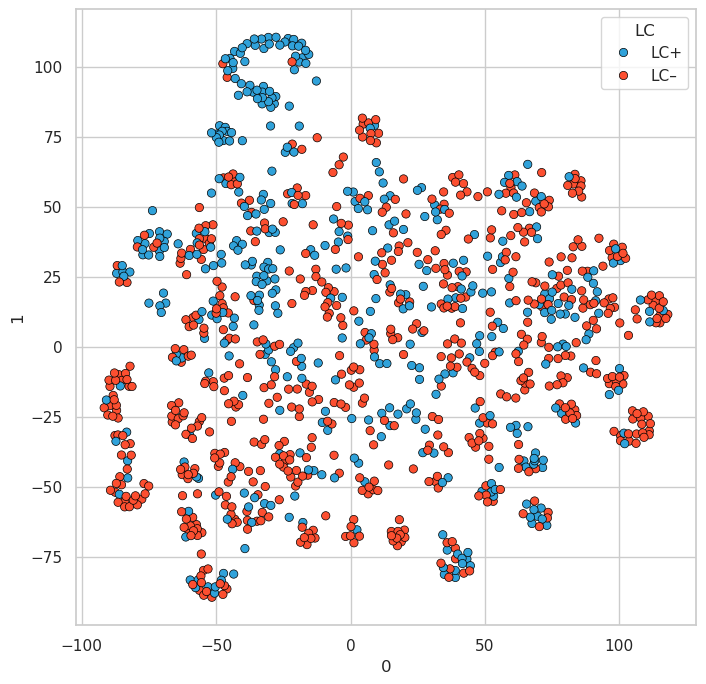

In [11]:
tmpDict = valSelTests['dfcmpltPreLC4']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':       50.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.2),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaled'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC–',1:'LC+'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]

## SITE1

In [10]:
tmpDict = valSelTests['dfcmpltPreLC3_SITE1']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.1),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaled'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5, s=50) #ax=ax[splot]

KeyError: 'dfcmpltPreLC3_SITE1'

## SITE2

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_404190/3064036970.py:27: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1.0, edgecolor='black', linewidth=0.5, s=50) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

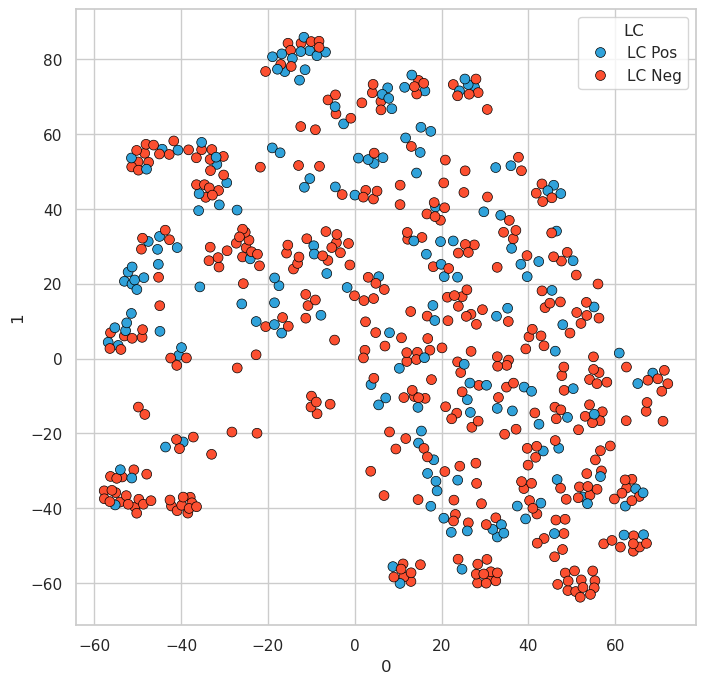

In [11]:
tmpDict = valSelTests['dfcmpltPreLC3_SITE2']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':       30.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.20),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaled'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap
#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1.0, edgecolor='black', linewidth=0.5, s=50) #ax=ax[splot]

## SITE3

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_404190/1746550083.py:28: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

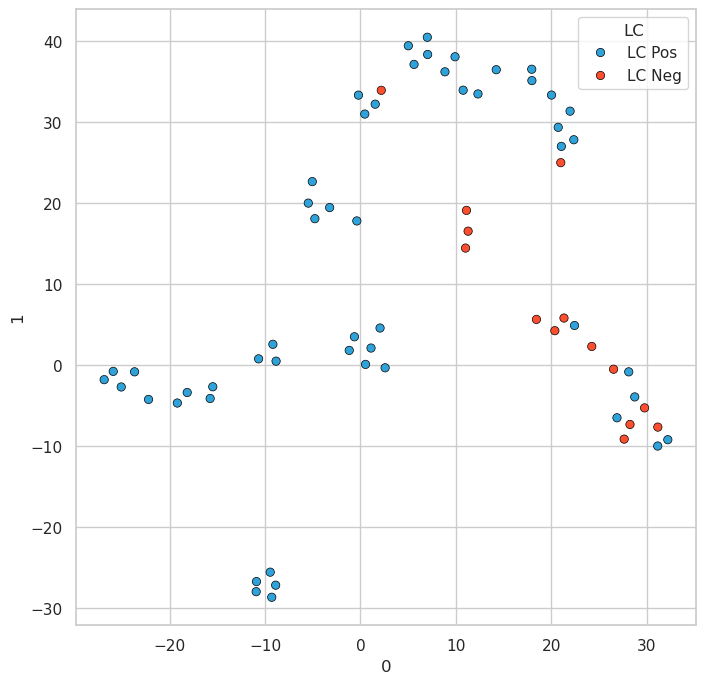

In [12]:
tmpDict = valSelTests['dfcmpltPreLC3_SITE3']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':       10.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.10),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaled'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]

## SITE4

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_404190/1900230157.py:28: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

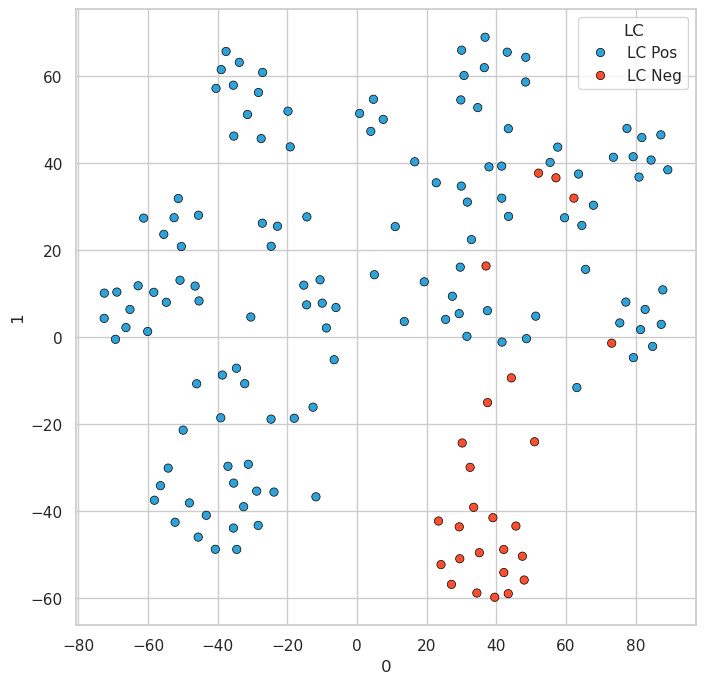

In [13]:
tmpDict = valSelTests['dfcmpltPreLC3_SITE4']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':      40.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.25),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaled'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5) #ax=ax[splot]

## SITE5

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_404190/276213321.py:28: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5,s=50) #ax=ax[splot]


<Axes: xlabel='0', ylabel='1'>

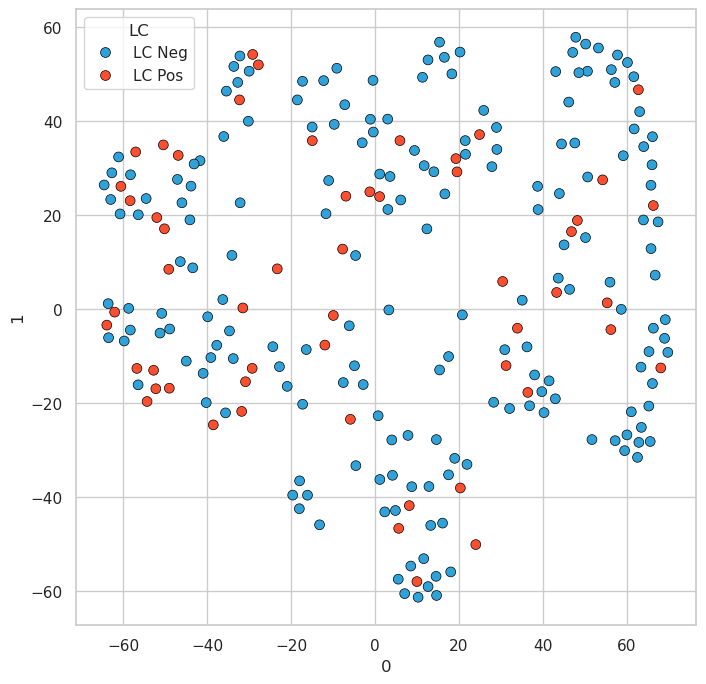

In [14]:
tmpDict = valSelTests['dfcmpltPreLC3_SITE5']

# UMAP
umap_parms = {
                'n_components': 2,
                'spread':      30.0,
                'random_state': 42,
                'n_neighbors': int(tmpDict['x_h'].shape[0]*0.15),
                'min_dist': 0.1
            }

scaler = MinMaxScaler().set_output(transform = "pandas")
x_h_scaled = scaler.fit_transform(tmpDict['x_h'])

tmpDict['x_h_scaled'] = x_h_scaled

mapper = umap.UMAP(**umap_parms, verbose=False)
mapper.fit(x_h_scaled)


dfumap = pd.DataFrame(mapper.embedding_, index=x_h_scaled.index)
dfumap['LC'] = tmpDict['data'].loc[x_h_scaled.index]['LC_STATUS'].map({0:'LC Neg',1:'LC Pos'})

tmpDict['umapRes'] = mapper
tmpDict['umap'] = dfumap

#plot umap
sns.scatterplot(data=dfumap, x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, edgecolor='black', linewidth=0.5,s=50) #ax=ax[splot]

# UMAP Plot Site Based - all tegether - same params

/home/mtrx/miniconda3/envs/clust/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/tmp/ipykernel_5151/4132690356.py:14: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, ax=ax[splot], edgecolor='black', linewidth=0.5, s=50)


KeyError: 'umap'

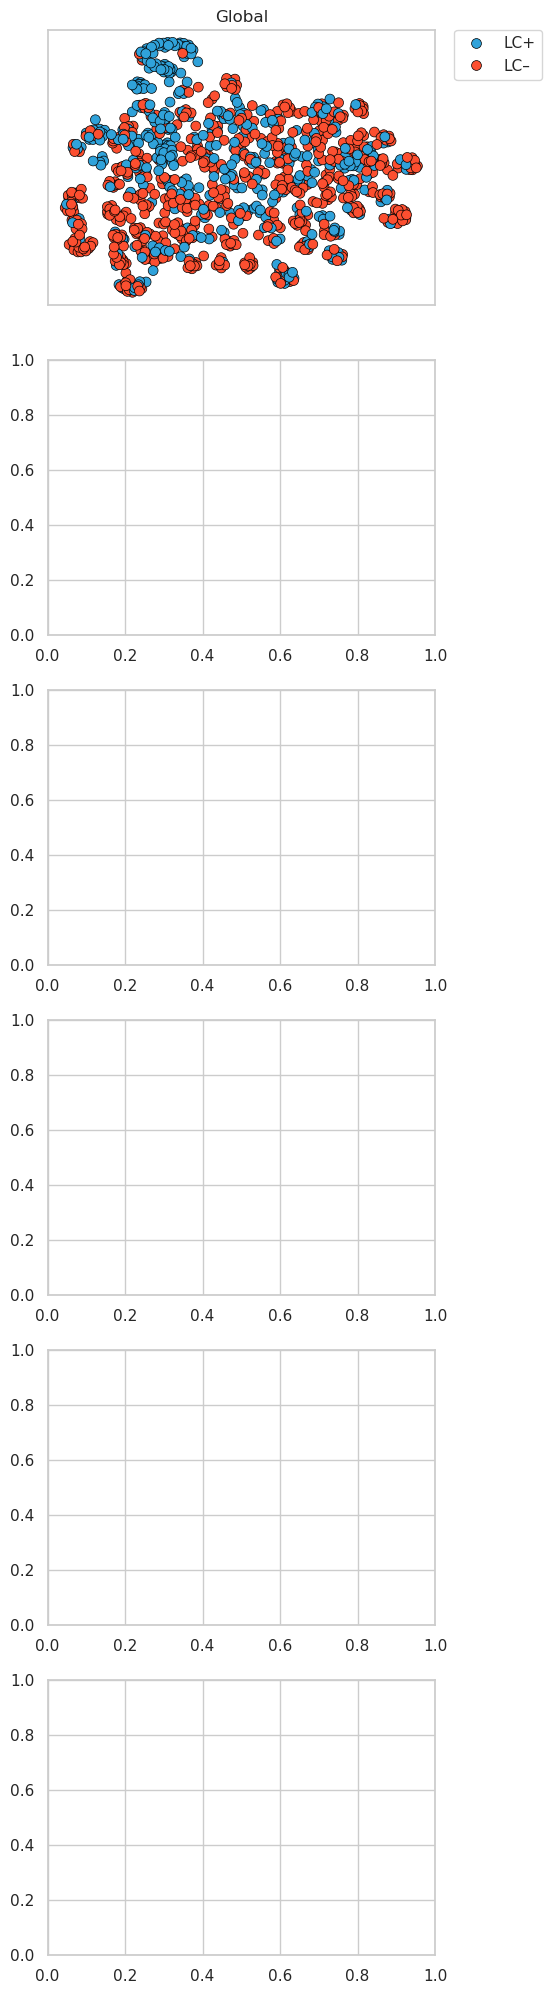

In [10]:
#init subplots
import umap.plot


sString = 'A;B;C;D;E;F'
fig, ax = plt.subplot_mosaic(sString,figsize=(5,25))

#go through sites and plot
for i, splot in enumerate(sString.replace(';','')):
    
    tmpDict = valSelTests[valSelKeys[i]] #get site dictionary

    #plot umap
    sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, ax=ax[splot], edgecolor='black', linewidth=0.5, s=50)
    
    #setup plot
    ax[splot].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[splot].set_xticks([]); ax[splot].set_yticks([])
    ax[splot].set_xlabel(""); ax[splot].set_ylabel("")
    ax[splot].set_title(tmpDict['site'])
    
    # umap.plot.points(tmpDict['umapRes'],labels=tmpDict['y_h'])
    
plt.savefig(f'{saveDir}/Fig2-SiteSpecific/Fig2-SiteSpecificwGlobal-UMAPonly.jpg', dpi=800, bbox_inches='tight', facecolor='white')

# Plot Fig 1

In [12]:
tmpDict = valSelTests['dfcmpltPreLC4']

In [15]:
tmpDict.keys()

dict_keys(['featlist', 'site', 'data', 'savedir', 'featDir', 'selCols', 'x_h', 'y_h', 'x_Tr', 'y_Tr', 'x_h_scaked', 'umapRes', 'umap'])

In [30]:
tmpDict.keys()

dict_keys(['featlist', 'site', 'data', 'savedir', 'featDir', 'selCols', 'x_h', 'y_h', 'x_Tr', 'y_Tr', 'x_h_scaked', 'umapRes', 'umap'])

In [40]:
exportData = deepcopy(tmpDict['x_h'])

In [41]:
exportData['LC_STATUS']=tmpDict['y_h']

In [42]:
exportData = MPutils.reorder_columns(exportData,['LC_STATUS'])

In [43]:
exportData.to_pickle('./OUTPUT/MP/GlobalHoldoutData.pickle')

In [13]:
nicefeat = pd.read_csv('OUTPUT/MP/niceFeatures.csv')
nicefeat = nicefeat.set_index('feature')
nicefeatclean = nicefeat['clean'].to_dict()
nicefeatcleanflipped = nicefeat['clean_flip'].to_dict()

In [14]:
from project_modules.classifcation import _shap_analysis as davidShap

model = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=42)


x_Tr_global = deepcopy(tmpDict['x_Tr']).rename(columns=nicefeatclean) #nicefeatcleanflipped
y_Tr_global = deepcopy(tmpDict['y_Tr'])

x_h_global = deepcopy(tmpDict['x_h']).rename(columns=nicefeatclean) #nicefeatcleanflipped


model.fit(x_Tr_global,y_Tr_global)

explainer = shap.TreeExplainer(model)

explanation = explainer(x_h_global)

In [22]:
dfShapFI = davidShap.shap_get_feature_importance(explainer,explanation,X=tmpDict['x_h'],top_N=10)
dfShapFI['FeatureClean'] = dfShapFI.Feature.map(nicefeatclean)
dfShapFI['FeatureCleanFlipped'] = dfShapFI.Feature.map(nicefeatcleanflipped)
dfShapFI

>>> SHAP feature importance
--------------------------------------------------
>>> ... Top 10 features: ['VAX-vaccinated' 'age' 'SYMPT-dizziness___1' 'SYMPT-sore_throat___1'
 'SYMPT-runny_nose_rhinorrhea___1' 'SYMPT-shortness_of_breath_dyspne___1'
 'SYMPT-fatigue___1' 'SYMPT-cough___1' 'CD-medication_received___5'
 'SYMPT-chest_pain___1']


,Feature,Importance,FeatureClean,FeatureCleanFlipped
0,VAX-vaccinated,1.000000,Vaccinated,Vaccinated
1,age,0.956478,Age,Age
2,SYMPT-dizziness___1,0.881922,CoV Dizziness,Dizziness CoV
3,SYMPT-sore_throat___1,0.620386,CoV Sore Throat,Sore Throat CoV
4,SYMPT-runny_nose_rhinorrhea___1,0.574954,CoV Rhinorrhea,Rhinorrhea CoV
5,SYMPT-shortness_of_breath_dyspne___1,0.565062,CoV Dyspnea,Dyspnea CoV
6,SYMPT-fatigue___1,0.397254,CoV Fatigue,Fatigue CoV
7,SYMPT-cough___1,0.359044,CoV Cough,Cough CoV
8,CD-medication_received___5,0.330489,CoV Antibiotics,Antibiotics CoV
9,SYMPT-chest_pain___1,0.249684,CoV Chest Pain,Chest Pain CoV


In [23]:
random_state = 42
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay, auc

def plotROCCurve(ax,fontsize=10):
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits)
    # classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    classifier = RandomForestClassifier(n_estimators=1000,max_depth=10,random_state=42)

    X = deepcopy(tmpDict['x_h'])
    X.reset_index(drop=True,inplace=True)
    y = deepcopy(tmpDict['y_h'])
    y.reset_index(drop=True,inplace=True)

    for fold, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X.iloc[train], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        # title=f"Mean ROC curve with variability",
        title='ROC Curve',
    )
    ax.legend(loc="lower right",fontsize=8)

In [24]:
x_h_global

,Age,Vaccinated,CoV Oxygen,PMHx Respiratory Tract,CoV Chest Pain,CoV Cough,CoV Dizziness,CoV Extremity Weakness/Numbness,CoV Fatigue,CoV Headache,CoV Rhinorrhea,CoV Dyspnea,CoV Sore Throat,CoV Weight Loss,PMHx Obesity,PMHx Psychiatric Disease,PMHx Sleep Disorder,CoV Vasopressor/Inotrope,CoV Anticoagulant,CoV Antibiotics,LC+ Respiratory Unknown Origin
0,34.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,55.0,1.0,0.0,0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,49.0,1.0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,48.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,23.0,1.0,0.0,0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,32.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1111,42.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1112,85.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1113,34.0,1.0,0.0,0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


/tmp/ipykernel_5978/1401180883.py:10: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, ax=ax['B'], edgecolor='black', linewidth=0.5, s=50)


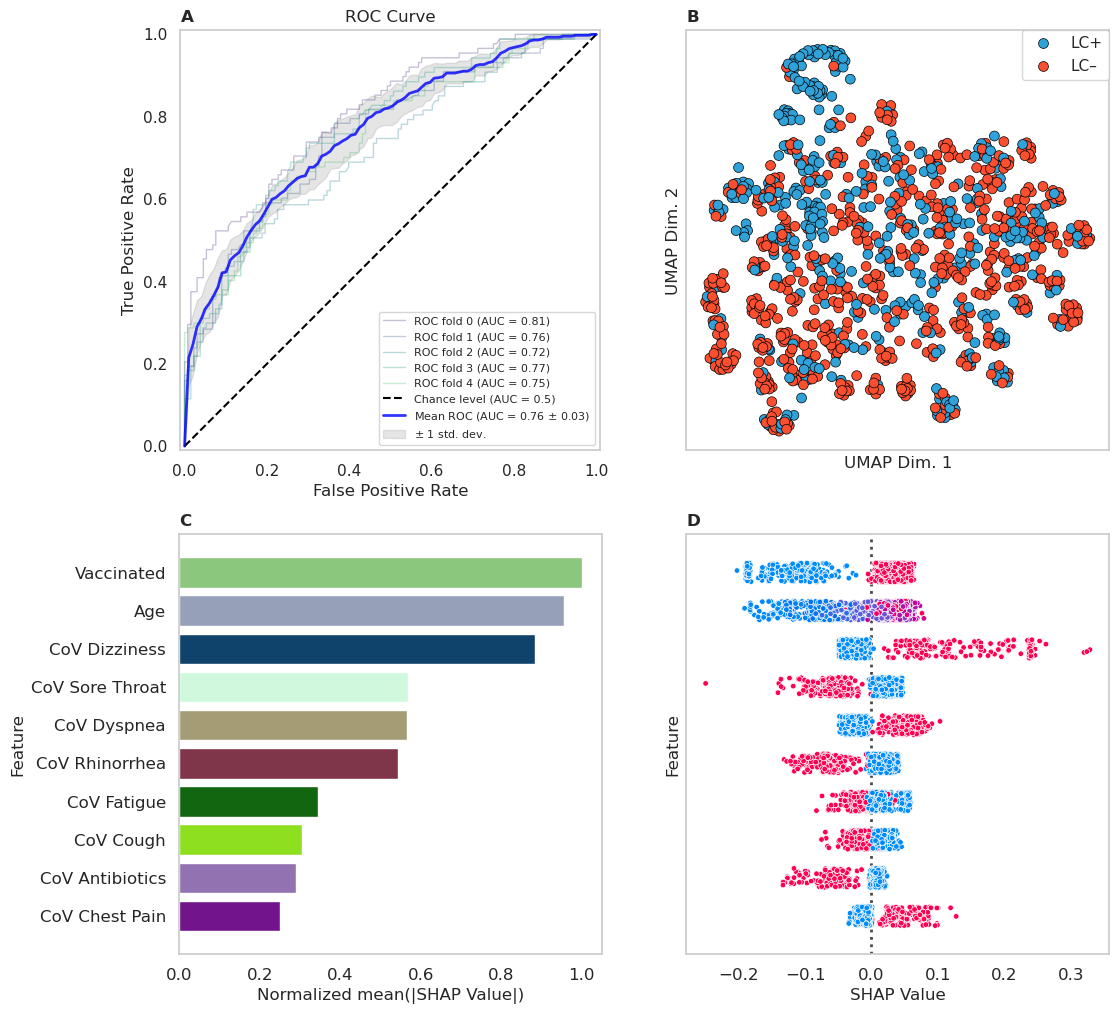

In [25]:
fontsize='medium'

sString = 'AB;CD'
fig, ax = plt.subplot_mosaic(sString,figsize=(12,12))

# davidShap.shap_cluster_2(ax=ax['B'],explainer=explainer,X=tmpDict['x_h'],y=tmpDict['y_h'])

plotROCCurve(ax['A'],fontsize)

sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=1, ax=ax['B'], edgecolor='black', linewidth=0.5, s=50)

#setup plot
ax['B'].legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
ax['B'].set_xticks([]); ax['B'].set_yticks([])
ax['B'].set_xlabel("UMAP Dim. 1"); ax['B'].set_ylabel("UMAP Dim. 2")
# ax['B'].set_title(tmpDict['site'])

# sns.barplot(data=dfShapFI.iloc[:10], x='Importance', y='FeatureCleanFlipped', hue='FeatureCleanFlipped',ax=ax['C'],palette=paletteSel_NFF)
# ax['C'].set_xlabel("Relative Importance"); ax['C'].set_ylabel("Features - Top 10/26")

davidShap.shap_plot_bar(ax=ax['C'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,feature_palette=paletteSel_NF,fontsize=fontsize)



# ax['C'].set_title('')

davidShap.shap_plot_points(ax=ax['D'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,fontsize=fontsize,normalize_values=False, suppress_yticks=True)

ax['A'].grid(False)
ax['B'].grid(False)
ax['C'].grid(False)
ax['D'].grid(False)




#set AB subplot identifier letters
ax['A'].set_title('A',  loc='left', fontsize='medium', fontweight='bold')
ax['B'].set_title('B', loc='left', fontsize='medium', fontweight='bold')
ax['C'].set_title('C', loc='left', fontsize='medium', fontweight='bold')
ax['D'].set_title('D', loc='left', fontsize='medium', fontweight='bold')

plt.savefig(f'{saveDir}/Fig1-Global/Fig1-Global-ROC-UMAP-SHAPFR-SHAPVal.jpg', dpi=800, bbox_inches='tight', facecolor='white')

/tmp/ipykernel_5978/2914351112.py:10: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.5, ax=ax['B'], edgecolor='black', linewidth=0.5, s=25)


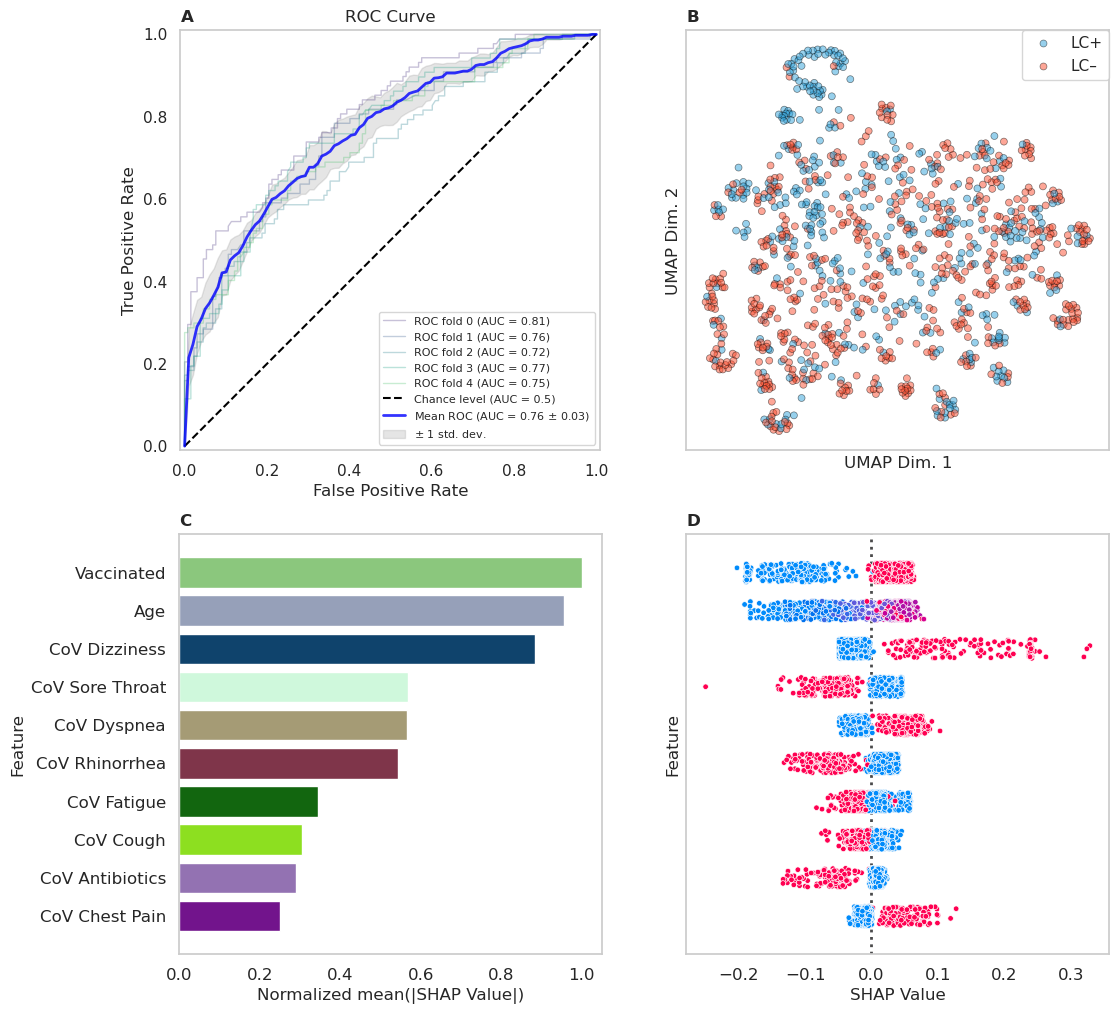

In [31]:
fontsize='medium'

sString = 'AB;CD'
fig, ax = plt.subplot_mosaic(sString,figsize=(12,12))

# davidShap.shap_cluster_2(ax=ax['B'],explainer=explainer,X=tmpDict['x_h'],y=tmpDict['y_h'])

plotROCCurve(ax['A'],fontsize)

sns.scatterplot(data=tmpDict['umap'], x=0, y=1, hue='LC',palette=cc.glasbey_hv, alpha=0.5, ax=ax['B'], edgecolor='black', linewidth=0.5, s=25)

#setup plot
ax['B'].legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)
ax['B'].set_xticks([]); ax['B'].set_yticks([])
ax['B'].set_xlabel("UMAP Dim. 1"); ax['B'].set_ylabel("UMAP Dim. 2")
# ax['B'].set_title(tmpDict['site'])

# sns.barplot(data=dfShapFI.iloc[:10], x='Importance', y='FeatureCleanFlipped', hue='FeatureCleanFlipped',ax=ax['C'],palette=paletteSel_NFF)
# ax['C'].set_xlabel("Relative Importance"); ax['C'].set_ylabel("Features - Top 10/26")

davidShap.shap_plot_bar(ax=ax['C'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,feature_palette=paletteSel_NF,fontsize=fontsize)



# ax['C'].set_title('')

davidShap.shap_plot_points(ax=ax['D'], explanation=explanation, X= x_h_global,target_class=1,plot_n_features=10,fontsize=fontsize,normalize_values=False, suppress_yticks=True)

ax['A'].grid(False)
ax['B'].grid(False)
ax['C'].grid(False)
ax['D'].grid(False)




#set AB subplot identifier letters
ax['A'].set_title('A',  loc='left', fontsize='medium', fontweight='bold')
ax['B'].set_title('B', loc='left', fontsize='medium', fontweight='bold')
ax['C'].set_title('C', loc='left', fontsize='medium', fontweight='bold')
ax['D'].set_title('D', loc='left', fontsize='medium', fontweight='bold')

plt.savefig(f'{saveDir}/Fig1-Global/Fig1-Global-ROC-UMAP-SHAPFR-SHAPVal.jpg', dpi=800, bbox_inches='tight', facecolor='white')